<a href="https://colab.research.google.com/github/dude123studios/AdvancedDeepLearning/blob/main/Transfer_Learning_on_MobileNetv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Shuffling and writing examples to /root/tensorflow_datasets/horses_or_humans/3.0.0.incompleteIMEFAL/horses_or_humans-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/horses_or_humans/3.0.0.incompleteIMEFAL/horses_or_humans-test.tfrecord


Dataset horses_or_humans downloaded and prepared to /root/tensorflow_datasets/horses_or_humans/3.0.0. Subsequent calls will reuse this data.


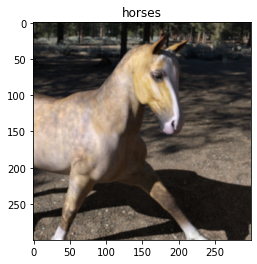

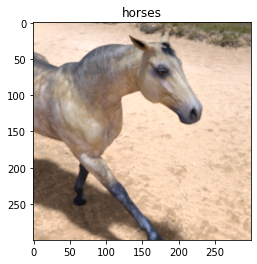

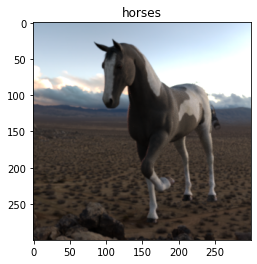

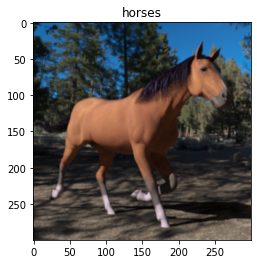

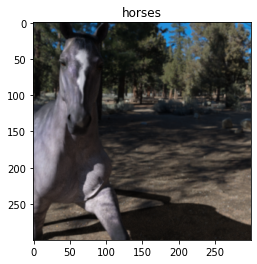

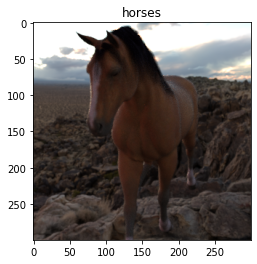

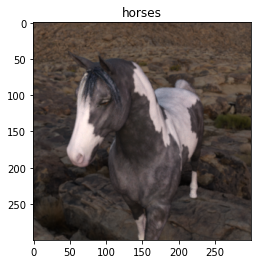

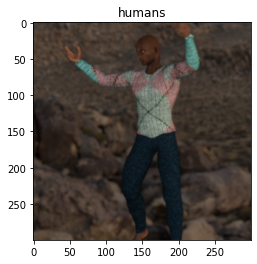

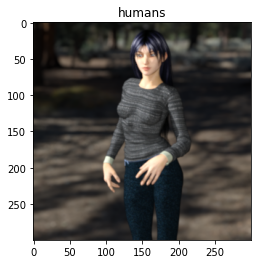

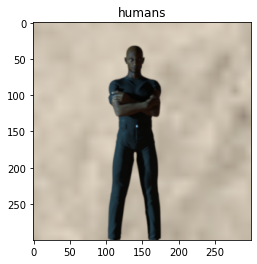

In [3]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt


(train,val,test),metadata = tfds.load('horses_or_humans',split=[
    'train[:80%]','train[80%:90%]','train[90%:]'
],with_info=True,as_supervised=True)
get_label_name = metadata.features['label'].int2str

def show_images(dataset):
    for image,label in dataset.take(10):
        plt.figure()
        plt.imshow(image)
        plt.title(get_label_name(label))

show_images(train)

In [4]:
IMG_SIZE = 160
def format_example(image,label):
    image = tf.cast(image,tf.float32)
    image = (image/127.5)-1
    image = tf.image.resize(image,(IMG_SIZE,IMG_SIZE))
    return image,label

train = train.map(format_example)
val =val.map(format_example)
test = test.map(format_example)

BATCH_SIZE = 32
SHUFFLE_BUFFER = 2000
train_batches = train.shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
val = val.batch(BATCH_SIZE)
test = test.batch(BATCH_SIZE)

In [17]:
IMG_SHAPE = (IMG_SIZE,IMG_SIZE,3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [6]:
for image_batch,label_batch in train_batches.take(1):
    pass
print(image_batch.shape)

(32, 160, 160, 3)


In [7]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [8]:
global_average_layer = tf.keras.layers.GlobalAvgPool2D()
feature_batch_av = global_average_layer(feature_batch)
print(feature_batch_av.shape)

(32, 1280)


In [9]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_av)
print(prediction_batch.shape)

(32, 1)


In [18]:

base_model.trainable = False
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [13]:
inital_epochs = 10
validation_steps = 4
loss0, accuracy0 = model.evaluate(val,steps=validation_steps)

4/4 [==============================] - 4s 443ms/step - loss: 2.9781 - accuracy: 0.6492


In [19]:
history = model.fit(train_batches,epochs=inital_epochs,validation_data=val)

Epoch 1/10
26/26 [==============================] - 25s 722ms/step - loss: 0.7711 - accuracy: 0.8540 - val_loss: 0.3396 - val_accuracy: 0.8824
Epoch 2/10
26/26 [==============================] - 21s 694ms/step - loss: 0.3746 - accuracy: 0.9197 - val_loss: 0.1215 - val_accuracy: 0.9510
Epoch 3/10
26/26 [==============================] - 21s 692ms/step - loss: 0.2670 - accuracy: 0.9567 - val_loss: 0.0578 - val_accuracy: 0.9804
Epoch 4/10
26/26 [==============================] - 21s 690ms/step - loss: 0.2843 - accuracy: 0.9726 - val_loss: 0.0278 - val_accuracy: 0.9902
Epoch 5/10
26/26 [==============================] - 21s 690ms/step - loss: 0.1392 - accuracy: 0.9815 - val_loss: 0.0258 - val_accuracy: 0.9902
Epoch 6/10
26/26 [==============================] - 21s 695ms/step - loss: 0.0708 - accuracy: 0.9894 - val_loss: 0.0174 - val_accuracy: 1.0000
Epoch 7/10
26/26 [==============================] - 21s 690ms/step - loss: 0.0443 - accuracy: 0.9938 - val_loss: 0.0106 - val_accuracy: 1.0000